In a [previous post](/posts/engineering_a_cup_of_coffee/) I thought about how one might approach making coffee, in a French press, as a chemical engineering problem. The obvious next step is to look at percolation methods like espresso, which is what I am exploring here.

The same basic principles of extraction and diffusion apply to an espresso maker as apply to a French press, and we expect the same basic parameters to be relevant: the particle size, solid phase diffusivity, etc. The major difference is that the liquid phase, water, is moving through a fixed bed of coffee particles and this significantly changes the mass transfer problem.

In the case of the French press I made the simplifying assumption that the system was well mixed, and so I could generally ignore the flow of the fluid. In the case of the espresso maker, it is more complicated than that.

In [1]:
#| echo: false
#| output: false
# This is some boiler plate to make the notebook stand alone
# Creates a temporary project and adds only the packages used
# in the notebook to the Project.toml

# If the notebook is in an environment with these packages 
# installed comment it out
using Pkg

Pkg.activate(; temp=true)
Pkg.add([PackageSpec(name="Plots", version="1.40.2"),
         PackageSpec(name="Unitful", version="1.19.0"),
         PackageSpec(name="Bessels", version="0.2.8"),
         PackageSpec(name="SpecialFunctions", version="2.3.1"),
         PackageSpec(name="LinearAlgebra"),
         PackageSpec(name="QuadGK", version="2.9.4"),
         PackageSpec(name="ApproxFun", version="0.13.25"),
         PackageSpec(name="OrdinaryDiffEq", version="6.74.0"),
         PackageSpec(name="SparseArrays", version="1.10.0")])
Pkg.instantiate();

using Plots, ApproxFun, OrdinaryDiffEq

  Activating new project at `/tmp/jl_pRhdgM`
   Resolving package versions...
    Updating `/tmp/jl_pRhdgM/Project.toml`
⌃ [28f2ccd6] + ApproxFun v0.13.25
  [0e736298] + Bessels v0.2.8
⌃ [1dea7af3] + OrdinaryDiffEq v6.74.0
  [91a5bcdd] + Plots v1.40.2
  [1fd47b50] + QuadGK v2.9.4
  [276daf66] + SpecialFunctions v2.3.1
  [1986cc42] + Unitful v1.19.0
  [37e2e46d] + LinearAlgebra
  [2f01184e] + SparseArrays v1.10.0
    Updating `/tmp/jl_pRhdgM/Manifest.toml`
  [47edcb42] + ADTypes v0.2.7
  [621f4979] + AbstractFFTs v1.5.0
  [79e6a3ab] + Adapt v4.0.4
⌃ [28f2ccd6] + ApproxFun v0.13.25
  [fbd15aa5] + ApproxFunBase v0.9.26
  [59844689] + ApproxFunFourier v0.3.27
  [b70543e2] + ApproxFunOrthogonalPolynomials v0.6.55
  [f8fcb915] + ApproxFunSingularities v0.3.20
⌅ [ec485272] + ArnoldiMethod v0.2.0
  [4fba245c] + ArrayInterface v7.9.0
  [4c555306] + ArrayLayouts v1.8.0
  [aae01518] + BandedMatrices v1.6.1
  [0e736298] + Bessels v0.2.8
  [d1d4a3ce] + BitFlags v0.1.8
  [62783981] + BitTwiddlingCon

## Packed Bed Leaching

[Making espresso](https://www.youtube.com/watch?v=c-27BTOAqig) involves packing coffee grounds into a cylindrical puck within a portafilter then passing hot water through the grounds under pressure, up to 10 bar[@cameron-2020 page 631]. The specific unit operation that corresponds to making espresso is packed bed leaching, in which the coffee solubles are being leached from the coffee grounds. In a lot of standard undergraduate texts on unit operations and separations, I find, this is not well explored. Especially the non-equilibrium case, which is exactly the situation when pulling a shot of espresso: one doesn't typically fully extract the beans and stops at some point in the transient regime. That said, the basic system is the same as *desorption* and so a good reference for what follows is often a text on chromatography and adsorption/desorption processes.

### Setting up the Governing Equations

The espresso puck can be modelled as a perfectly cylindrical packed bed of ground coffee. Meaning both that the bed is a perfect cylinder and that the grounds are perfectly evenly distributed, i.e. has a constant porosity $\varepsilon$. A lot of technique goes into [preparing the puck](https://www.youtube.com/watch?v=xb3IxAr4RCo), to ensure the grounds are evenly distributed in the packed bed and the distribution of water through the bed is even, so this is a reasonable assumption.

::: {#fig-domain}


The problem domain, a cylindrical puck of coffee.
:::

In practice the pressure can vary over the course of the shot, but for simplicity I am only considering the case where the pressure is constant and, consequently, the flow rate of water is constant. We can simplify the flow condition more by assuming plug-flow, i.e. the velocity is a constant throughout. One final simplifying assumption is that the espresso is pulled at a constant temperature, this ensures the physical properties of water are also constant, e.g. constant density and viscosity.

All of these assumptions, at their core, are to eliminate various partial derivatives and narrow down the governing equations to only core variables.

#### Liquid Phase
Zooming in on a thin slice of the packed bed with depth, *&Delta;z*, we can take a mass balance of the liquid phase.

::: {#fig-mt1}


Mass transfer in the thin slice of the column.
:::

The mass flow into the liquid phase can be due to:

+ advection, *Qc*, where *c* is the liquid phase concentration entering the slice and *Q* is the volumetric flow rate
+ axial diffusion, $\varepsilon A J_z$, where *J<sub>z</sub>* is the mass flux at the top of the slice and $\varepsilon A$ is the porous area of the top of the slice, i.e. the area available to liquid flux.
+ mass transfer from the coffee grounds (the solid phase), $A_s J_s$, where *J<sub>s</sub>* is the mass flux of solubles from the grounds into the liquid phase and *A<sub>s</sub>* is the surface area of the grounds

Similarly the mass flow out of the liquid phase can be due to advection or axial diffusion out the bottom of the slice. Putting that together into a mass balance we have

$$ { {d m_l} \over {d t} } = Q c_z - Q c_{z + \Delta z} + \varepsilon A J_z - \varepsilon A J_{z+\Delta z} + A_s J_s $$

$$ V_l { {d c} \over {d t} } = - Q \Delta c - \varepsilon A \Delta J_z + a_s V_s J_s $$

where *a<sub>s</sub>* is the specific area of the coffee grounds, the surface area per unit volume. By writing the volume of the liquid phase and solid phase in terms of porosity and cross sectional area, *A*, we can cancel out some terms.

$$ \varepsilon A \Delta z { {d c} \over {d t} } = - \varepsilon A v \Delta c - \varepsilon A \Delta J_z + \left( 1 - \varepsilon \right) A {\Delta z} a_s J_s$$

$$ { {d c} \over {d t} } = - v { {\Delta c} \over {\Delta z} } - { {\Delta J_z} \over {\Delta z} } + \left( {1 - \varepsilon} \over \varepsilon \right) a_s J_s $$

In the limit *&Delta;z &rarr; 0* this becomes

$$ { {\partial c} \over {\partial t} } = - v { {\partial c} \over {\partial z} } - { {\partial J_z} \over {\partial z} } + \left({ 1 - \varepsilon } \over \varepsilon \right) a_s J_s $$

Assuming axial diffusion is [Fickian](https://en.wikipedia.org/wiki/Fick's_laws_of_diffusion)

$$ { {\partial c} \over {\partial t} } = \mathscr{D}_l { {\partial^2 c} \over {\partial z^2} } - v { {\partial c} \over {\partial z} } + \left({ 1 - \varepsilon } \over \varepsilon \right) a_s J_s $$


#### Solid Phase

For the solid phase, I am assuming a uniform bed of spherical particles, all with the same radius *b*. Actual coffee grounds, beyond being non-spherical, are also composed of multiple phases: the solid phase, the coffee oils, and the liquid water phase within the micro-porous structure of the bean. To simplify things greatly, I am assuming an *effective* solid phase diffusion, wherein diffusion within the particle of coffee follows Fick's law with an effective diffusion coefficient that combines all of that complexity into a single parameter.

$$ { {\partial q} \over {\partial t} } = \mathscr{D}_s \nabla^2 q$$

In spherical coordinates, this becomes

$$ { {\partial q} \over {\partial t} } = \mathscr{D}_s \frac{1}{r^2} {\partial \over {\partial r} } \left( r^2 { {\partial q} \over {\partial r} } \right)$$

$$ { {\partial q} \over {\partial t} } = \mathscr{D}_s \left( { {\partial^2 q} \over {\partial r^2} }  + {2 \over r} { {\partial q} \over {\partial r} }  \right) $$

Where the solid phase concentration, *q*, is in units of mass per unit volume.

#### Thin Film

Connecting the two phases, the liquid coffee and the solid coffee grounds, is a thin film. This is where the inter-phase mass transfer occurs, and I assume it follows a linear mass transfer relation.

$$ J_s = h \left( c_{s} -  c \right) $$

Where *h* is the mass transfer coefficient and *c<sub>s</sub>* is the liquid concentration immediately at the solid surface. I am making the additional assumption that this concentration is in equilibrium with the solid phase concentration at the surface, and that equilibrium is linear, i.e.

$$ K = c_{s}/q_{s} = \mathrm{constant} $$

### Initial Conditions

The initial conditions for espresso are complicated. The bed is initially full of air and the first phase of making espresso, the [pre-infusion](https://www.youtube.com/watch?v=SwBNivAITdY), is to saturate the bed with hot water at a lower pressure than is used during the main extraction phase. This initial step has a very complicated multi-phase flow and mass transfer which dramatically complicates the model and most papers I've read avoid this by making one of two simplifying assumptions:

1. The bed is initially full of water, but that water has no coffee extracted into it.
2. The bed is initially full of water, and that water is in equilibrium with the coffee grounds (e.g. fully saturated).

Basically everyone ignores pre-infusion and focuses on the main extraction phase, after the bed has been filled with water. I am going to make the second assumption, that after pre-infusion the bed is full of water that is in equilibrium with the solids. This is in part because it is a convenient initial condition for solving the partial differential equations[@schwartzberg-1987 page 559] and in part because the actual volume of water in the bed is small and the pre-infusion step, which can take between 5-10s, is sufficiently long enough that the water will have extracted some coffee.

For my model, the initial conditions are:

+ the solid concentration in the grounds is the saturation concentration
+ the liquid concentration in the bulk is, initially, in equilibrium and also saturated
+ the boundary condition is that the water entering the system has a concentration 0 mg/m<sup>3</sup> coffee solubles

Several recent papers that numerically integrate the pde use some variation on the first assumption[^3] and this will be the major difference between my approach and some of the published literature.

[^3]: @cameron-2020 page 635; @moroney-2015 page 225; @guerra-2024 page 5

## Determining the Parameters of the System

I am assuming the water and portafilter are isothermal and the liquid phase has the same physical properties of pure water throughout. This is not entirely true in that the system is not perfectly isothermal but also the process of extracting coffee changes the density and viscosity of the coffee. I am assuming this effect is small and can be ignored.

In [2]:
#| output: false
using Unitful

# physical properties coffee
# assumed to be water at 90C and 10bar
ρ = 965.34u"kg/m^3"
μ = 0.282*0.001u"Pa*s"
ν = μ/ρ
ν = upreferred(ν)

2.921250543849835e-7 m^2 s^-1

### Parameters of the Packed Bed

The most significant factors for both modelling the flow and also determining the mass transfer parameters are the features of the espresso bed itself. Primarily the porosity and the particle size. For simplicity I am taking both of these from the literature for actual espresso shots[@cameron-2020 supplemental materials], but in practice these are probably the most difficult to derive for someone making espresso at home, with the sorts of tools available in a kitchen.

The porosity will vary from espresso shot to espresso shot, as it is a function of the particle size distribution, the distribution within the portafilter, and also the degree of tamping. Furthermore the porosity of the dry bed will not be the same as the porosity of the bed once fully saturated with water. The coffee grounds will swell somewhat and any liquid within a particle is already accounted for in the *effective* solid phase mass transfer, including it in an estimate of the porosity would be double counting. One could try measuring the mass and volume of the spent puck and calculate it directly, but I'm not sure how one would account for the volume of water absorbed into the grounds while discarding the water that is only in the void space between coffee particles.

The particle size distribution for a given coffee, grinder, and grind setting can be measured in a variety of ways, including with an app on one's phone[@gagne-2020 page 199] where in this case we are interested in the [Sauter mean radius](https://en.wikipedia.org/wiki/Sauter_mean_diameter) as we are assuming a bed of uniform spherical particles. Camera based approaches have one main weakness in that particles of coffee have microscopic pores that increase the apparent surface area but are too small to be resolved by a typical camera. Laboratory methods tend to measure the adsorption of a neutral substance, like nitrogen, to measure this. Not something one is going to be doing in the kitchen.

The flow rate through the bed is also an important factor, I am simply taking the total volume of the shot divided by the time taken to pull a shot as the flow rate, but this is only a rough estimate. The pre-infusion phase adds water at a lower flow rate and it is only the flow after the pre-infusion has ended that is relevant to the problem. This can be measured with some higher end coffee scales that can output the time series of mass measurements during a shot. I don't have one of these, but it's not out of the question that I could just write down the mass and time at several points. Or take a video of my coffee scale's screen during the actual shot and extract the data very tediously that way.

In [3]:
#| output: false
# Cameron et al, "Systematically Improving Espresso," supplemental materials.

# porosity and particle size
ε = 1 - 0.8272
b = 12e-6u"m"

# bed size
R_pb = 29.2e-3u"m"
L_pb = 18.7e-3u"m"
A_pb = π*R_pb^2

# shot size
M_shot = 0.04u"kg" # the mass of the espresso shot
t_shot = 20u"s"
Q_shot = (M_shot/ρ)/t_shot

v_s = Q_shot/A_pb # superficial velocity, m/s
v = v_s/ε

0.004476003112601867 m s^-1

From the dimensions of the packed bed, assumed porosity, and assumed flow rate, I can calculate the time for the water to traverse the bed.

In [4]:
(ε*A_pb*L_pb)/Q_shot

4.177834449522944 s

### Mass Transfer Parameters

In practice, for a lot of chemical engineering mass transfer problems, accurate mass transfer coefficients and diffusivities are hard to come by. This is equally true for the espresso system. I am going to be using a literature value for the effective solid phase diffusion, but then estimating the remainder from correlations.

In [5]:
#| output: false
# effective solid phase diffusivity
# Cameron et al, "Systematically Improving Espresso," 11.
𝒟ₛ = 6.25e-10u"m^2/s"

# (stagnant) liquid diffusivity
# Schwartzberg, “Leaching – Organic Materials,” 557.
D = 5*𝒟ₛ

3.125e-9 m^2 s^-1

The thin film mass transfer coefficient is typically estimated from the [Sherwood number](https://en.wikipedia.org/wiki/Sherwood_number) which is a function of the [Reynolds number](https://en.wikipedia.org/wiki/Reynolds_number) and [Schmidt number](https://en.wikipedia.org/wiki/Schmidt_number)

In [6]:
#| output: false
# Reynolds number
Re = v_s*(2b)/ν

0.0635442932057411

In [7]:
#| output: false
# Schmidt number
Sc = ν/D

93.48001740319472

The Sherwood number can be estimated using the Wilson-Geankopolis correlation for packed bed flow

In [8]:
#| output: false
# Wilson-Geankopolis correlation
# Hottel et al, "Heat and Mass Transfer," 5-77.
Sh = (1.09/ε)*∛(Re*Sc)

11.423903849025136

Giving the thin film mass transfer coefficient

In [9]:
h = Sh*D/(2b)

0.0014874874803418145 m s^-1

The axial diffusion can be calculated using the Edwards-Richardson correlation

In [10]:
#| output: false
# Edwards-Richardson correlation
# LeVan and Carta, "Adsoprtion and Ion Exchange," 16-22.
γ₁ = 0.45 + 0.55*ε
γ₂ = 0.5*(1 + 13γ₁*ε/(Re*Sc))^-1
Pe = ( γ₁*ε/(Re*Sc) + γ₂ )^-1

2.323377782391481

In [11]:
𝒟ₗ = v*(2b)/Pe

4.623616336378663e-8 m^2 s^-1

### Equilibrium Constant

I am using literature values for the saturated concentration of solubles both in the bean and in the coffee, and calculating an equilibrium constant from that.

In [12]:
# saturation concentrations
# Cameron et al, "Systematically Improving Espresso," 11.
q_sat = 118.0u"kg/m^3"
c_sat = 212.4u"kg/m^3"
K = q_sat/c_sat

0.5555555555555556

### A Packed Bed Data Structure

Looking forward a little bit, I know that I will be using multiple approaches to the packed bed model and keeping track of all of the model parameters can be tricky. Especially in a notebook where everything is in the global name space. Which is why I think it is prudent to define a `PackedBed` data structure to contain all of the model parameters.

In [13]:
struct PackedBed
    q₀
    K
    𝒟ₛ
    𝒟ₗ
    h
    ε
    b
    c₀
    v
end

In [14]:
#| output: false
# initial concentration
c₀ = 0.0u"kg/m^3"

0.0 kg m^-3

In [15]:
pb = PackedBed(q_sat, K, 𝒟ₛ, 𝒟ₗ, h, ε, b, c₀, v);

## Anzelius' Integral Solution

A good first approach to solving the pde is to try simplifying the mass transfer problem by eliminating some of the diffusion terms. Making the following simplifications:

+ the rate of mass transfer across the thin film dominates, and thus the solid phase diffusion can be neglected
+ the mass flow into a given slice of the packed bed is dominated by advection, and the axial dispersion can be neglected

The governing equations can be reduced to

$$ { {\partial c} \over {\partial t} } = - v { {\partial c} \over {\partial z} } + \left({ 1 - \varepsilon } \over \varepsilon \right) a_s J_s $$

$$ { {\partial q} \over {\partial t} } = - a_s J_s $$

with

$$ J_s = h \left( c_{s} -  c \right) $$

This is a dramatically simpler model, eliminating much of the real complexity of the mass transfer. However an *effective* mass transfer coefficient, *h*, can be fit from measured data that combines the solid diffusion and thin film mass transfer.[^6] Similarly an effective mass transfer coefficient can be calculated by addition of linear mass transfer resistances. Essentially this is shifting some of the complexity out of the governing equations and into the parameters. This is a fairly common model for packed beds and was first solved, for the equivalent heat transfer case, by Anzelius and independently by Schumann.[^7] What follows is a general sketch of a solution.

[^6]: See @moroney-2019 for an example of this model being used for espresso extraction.

[^7]: @anzelius-1926; @schumann-1929

The first step is to transform this pde into dimensionless form[^8], first by introducing a dimensionless time $\tau = \frac{h a_s}{K} \left( t - \frac{z}{v} \right)$. Which, when substituted into the equation for the solid phase, becomes

$$ {{\partial q} \over {\partial \tau}} = K \left( c -  c_{s} \right) $$

Further introducing a dimensionless space $\xi = \frac{h a_s}{m v} z$ where $m = \left({ 1 - \varepsilon } \over \varepsilon \right)$ transforms the equation for the liquid phase into

$$ {{\partial c} \over {\partial \xi}} = c_s - c $$

By defining a dimensionless liquid phase concentration 

$$ u = {{c - \frac{q_0}{K}} \over {c_0 - \frac{q_0}{K}}} $$

where *q<sub>0</sub>* is the initial concentration of the solid phase and *c<sub>0</sub>* is the concentration in the water at z=0. We can re-write the equation for the liquid phase as

$$ {{\partial u} \over {\partial \xi}} = {{q - q_0} \over {K c_0 - q_0}} - u $$

[^8]: Setting the pde in dimensionless form follows @bird-2007 pages 753-755

Letting

$$ y = { {q - q_0} \over {K c_0 - q_0} } $$

the final system of equations is then

$$ { {\partial u} \over {\partial \xi} } = y - u $$

$$ { {\partial y} \over {\partial \tau} } = u - y $$

Which, at this point, is just something that you can look up in Carslaw and Jaeger[@carslaw-1959 page 393]. The solution follows directly from taking the Laplace transform of ${ {\partial y} \over {\partial \tau} }$, with respect to *&tau;*, which gives

$$ sY = U - Y$$

$$ Y = \frac{1}{s+1}U $$

then taking the Laplace transform of ${ {\partial u} \over {\partial \xi} }$, with respect to *&tau;* gives

$$ { {d U} \over {d \xi} } = Y - U = \frac{-s}{s+1}U  $$

which is a differential equation that can be easily solved using the initial condition *u(0) = 1* or, in the Laplace domain, *U(0) = 1/s*

$$ U = \frac{1}{s} \exp\left( \frac{-s}{s+1} \xi \right) $$

Inverting this requires a little work, though not as much as it may seem. I am departing from Bird[@bird-2007 pages 762-763] since I find their approach mystifying. It is clearly designed to reverse engineer a particular form of the answer as opposed to arriving at it naturally. The approach in Carslaw and Jaeger is more intuitive[^12] and is what I am following here.

[^12]: @carslaw-1959 pages 393-394; and also @goldstein-1953 pages 153-158.

First, recognize that

$$ \frac{1}{s} \exp\left( \frac{-s}{s+1} \xi \right) = \exp\left( -\xi \right) \frac{1}{s} \exp\left( \frac{1}{s+1} \xi \right) $$

Then, looking at a table of Laplace transforms we find[^13]

[^13]: With the caveat that you need a *good* table of Laplace transforms, most undergraduate textbooks have a very brief one. The tables in Carslaw and Jaeger are extensive and Perry's is also a good reference.

$$ \mathscr{L}^{-1} \left\{ \frac{1}{s} \exp\left( \frac{1}{s} x \right) \right\} = I_0 \left( 2 \sqrt{xt} \right)$$

where *I<sub>0</sub>* is the [modified Bessel function of the first kind](https://en.wikipedia.org/wiki/Bessel_function#Modified_Bessel_functions:_I%CE%B1,_K%CE%B1). A basic property of Laplace transforms is that 

$$ \mathscr{L}^{-1} \left\{ F(s+a) \right\} = \exp(-at)f(t) $$

from which it follows that

$$ \mathscr{L}^{-1} \left\{ \frac{1}{s+1} \exp\left( \frac{1}{s+1} x \right) \right\} = \exp\left( -t \right) I_0 \left( 2 \sqrt{xt} \right)$$

Another property of Laplace transforms is that 

$$ \mathscr{L}^{-1} \left\{ \frac{1}{s} F(s) \right\} = \int_0^t f\left( \lambda \right) d\lambda $$

which gives

$$ \mathscr{L}^{-1} \left\{ \frac{1}{s} \frac{1}{s+1} \exp\left( \frac{1}{s+1} x \right) \right\} = \int_0^t \exp\left( -\lambda \right) I_0 \left( 2 \sqrt{x \lambda} \right) d\lambda$$

Which is laying the groundwork for the observation that since

$$ \frac{1}{s} - \frac{1}{s+1} = \frac{1}{s}\frac{1}{s+1} $$

then

$$ \frac{1}{s} = \frac{1}{s+1} + \frac{1}{s}\frac{1}{s+1} $$

and *U* can be rewritten as

$$ U = \exp\left( -\xi \right) \left[ \frac{1}{s+1} \exp\left( \frac{1}{s+1} \xi \right) +\frac{1}{s} \frac{1}{s+1} \exp\left( \frac{1}{s+1} \xi \right) \right] $$

then by taking the inverse Laplace transform

$$ u = \exp\left( -\xi \right) \left[ \exp\left( - \tau \right) I_0 \left( 2 \sqrt{\tau \xi} \right) + \int_0^\tau \exp\left( -\lambda \right) I_0 \left( 2 \sqrt{\lambda \xi} \right) d\lambda \right] $$

$$ u = \exp\left( -(\tau + \xi) \right) I_0 \left( 2 \sqrt{\tau \xi} \right) + \int_0^\tau \exp\left( -(\lambda + \xi) \right) I_0 \left( 2 \sqrt{\lambda \xi} \right) d\lambda $$

This is the solution that Schumann[^14] arrives at via a different means, though it is not in the form one generally sees in the standard references. To get there, we must take advantage of some properties of the *Anzelius J Function* (named because it is the solution to this differential equation).[@goldstein-1953 page 160]

[^14]: This is equation 27 in @schumann-1929 page 409.

$$ J\left( x, y \right) = 1 - \int_0^x \exp\left( -(\lambda + y) \right) I_0 \left( 2 \sqrt{\lambda y} \right) d\lambda $$

$$ J\left( x, y \right) + J\left( y, x \right) = 1 + \exp\left( -(x+y) \right) I_0 \left( 2 \sqrt{ x y} \right) $$

from which we can see that

$$ u = \exp\left( -(\xi + \tau) \right) I_0 \left( 2 \sqrt{\xi \tau} \right) + 1 - J\left( \tau, \xi \right) = J\left( \xi, \tau \right) $$

and finally

$$ u = 1 - \int_0^\xi \exp\left( - (\tau + \lambda) \right) I_0 \left( 2 \sqrt{\tau \lambda} \right) d\lambda $$

Which is the form typically given in references. I think it is important to pause here and comment that this answer is not *the* answer, it is *an* answer. Both the solution above from taking the inverse Laplace transform and this solution are valid and, in fact, both are used when evaluating the Anzelius J function. It just happens to be the case that the latter result is what one tends to see in the literature.

### Defining the Anzelius Solution

At this point we can calculate the dimensionless space and time for a point at the exit of the espresso bed, and at a similar point in (dimensionless) time.

In [16]:
z = L_pb

m  = ε/(1-ε)
aᵥ = 3/b
ξ  = (h*aᵥ*z)/(m*v)

# τ = ξ
t = (K/(h*aᵥ))*ξ + z/v
τ  = (h*aᵥ/K)*(t - z/v)

@show ξ; @show τ;

ξ = 7437.232219350375
τ = 7437.232219350374


It is convenient to create an `AnzeliusSolution` struct that takes a `PackedBed` and a particular point in space and generates a datatype that allows us to go back and forth between the problem in dimensionless form and the problem in actual units.

In [17]:
#| output: false
struct AnzeliusSolution{F,Q1,Q2}
    ξ::F
    τ₁::Q1
    τ₂::Q2
    pb::PackedBed
end

function AnzeliusSolution(z, pb::PackedBed)
    m  = ε/(1-ε) 
    aᵥ = 3/pb.b
    ξ  = (pb.h*aᵥ*z)/(m*pb.v)
    τ₁ = (pb.h*aᵥ/pb.K)
    τ₂ = τ₁*(z/pb.v)

    return AnzeliusSolution(ξ, τ₁, τ₂, pb)
end

AnzeliusSolution

In [18]:
anzelius = AnzeliusSolution(z, pb);

### Evaluating the Products of Exponentials and Bessel Functions

Generally the Anzelius solution is given in terms of an integral of a Bessel function that is wildly impractical to numerically integrate directly as written. For an example, Bird[@bird-2007 page 755] gives this as the the solution:

$$ u = 1 - \int_0^\xi \exp\left( - (\tau + \lambda) \right) J_0 \left( i \sqrt{4\tau \lambda} \right) d\lambda $$

where *J<sub>0</sub>* in this case is the [Bessel function of the first kind](https://en.wikipedia.org/wiki/Bessel_function#Bessel_functions_of_the_first_kind:_J%CE%B1) (not the Anzelius J function). This is correct, however, attempting to use it as written will run aground on numerical difficulties at even moderately large values of *&tau;*. The first issue with this form of the answer is that it requires one to cast everything into complex values only to cast back into floats (the answer is a real number), but the most important issue is that the integrand is the product of an exponential that decays rapidly to zero and a Bessel function that blows up rapidly to infinity. For even moderate values of *&tau;* this leads to `NaN` errors of the type `0*Inf`.

When I was first playing around with this I attempted to integrate it as is. After that clearly didn't work, I looked into whether or not there are scaled versions of the Bessel function. I think this is a good practice that maybe isn't taught well in school: often functions like Bessel functions or the Gamma function explode to large numbers that would overflow, thus leading to `NaN` errors, consequently libraries of special functions tend to have scaled or log versions. [Bessels.jl](https://juliamath.github.io/Bessels.jl/stable/API/#Bessels.besseli0x) has an exponentially scaled version of *I<sub>0</sub>* that works perfectly for what I need, with the exponentially scaled version being

$$ I_{x,0}(z) = \exp(-z) I_0(z) $$

By completing the square we can rewrite

$$ u = 1 - \int_0^\xi \exp\left( - (\tau + \lambda) \right) I_0 \left( 2 \sqrt{\tau \lambda} \right) d\lambda $$

as

$$ u = 1 - \int_0^\xi \exp\left( - \left( \sqrt{\tau} - \sqrt{\lambda} \right)^2 \right) \exp\left(- 2 \sqrt{\tau \lambda} \right) I_0 \left( 2 \sqrt{\tau \lambda} \right) d\lambda $$

$$ u =  1 - \int_0^\xi \exp\left( - \left( \sqrt{\tau} - \sqrt{\lambda} \right)^2 \right) I_{x,0} \left( 2 \sqrt{\tau \lambda} \right) d\lambda $$

Below is a figure showing a plot of the integrand for a value of *&tau;* much smaller than our particular example, just for illustration. The first curve is the original version of the solution (shifted up for visibility), which begins to fail due to `NaN` errors part-way up the curve (where the red X is). The second curve uses the exponentially scaled modified Bessel function and does not have this issue. The larger the *&tau;* the earlier problems arrive and by the time we get to the value of *&tau;* being used for this example the integrand doesn't evaluate to any positive value prior to turning into `NaN`s.

In [19]:
#| output: false
using Bessels:besselj0, besseli0x

f_orig(λ, τ) = exp(-(τ+λ))*real(besselj0(im*√(complex(4τ*λ))))

fₐ(λ, τ) = exp(-(√(τ)-√(λ))^2)*besseli0x(√(4τ*λ))

fₐ (generic function with 1 method)

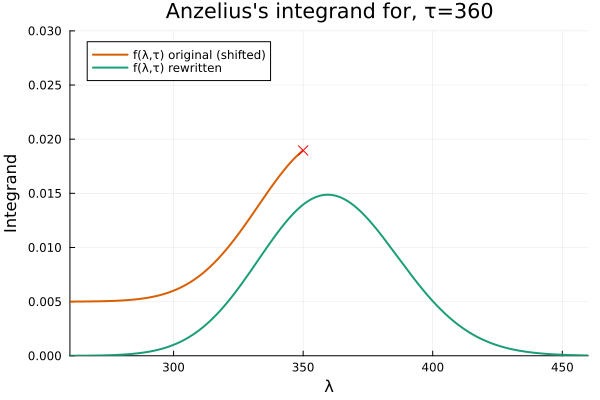

In [20]:
#| echo: false
#| label: fig-anz-int
#| fig-cap: "The Anzelius integrand, the upper curve represents the original form which encounters numerical difficulties and fails to return valid answers after the red X, the lower curve is the transformed form of the integrand that does not have these difficulties."

using Plots

colours = palette(:Dark2_8);

let τ=360
    plot( x -> f_orig(x, τ)+0.005, xlims=(τ-100, τ+100), label="f(λ,τ) original (shifted)", color=colours[2], linestyle=:solid, lw=2)
    plot!(x -> fₐ(x, τ), label="f(λ,τ) rewritten", color=colours[1], linestyle=:solid, lw=2,)
    plot!( [τ-10], [fₐ(τ-10, τ)+0.005], seriestype=:scatter, markershape=:xcross, color=:red, markersize = 5, lab=false)
    plot!( ylim=(0,0.03), xlabel="λ", ylabel="Integrand", title="Anzelius's integrand for, τ=$τ")
    
end


### Integration by Gauss-Kronold

Now that we have a version of the integrand that we can actually calculate, the obvious approach is to integrate using a standard package for numerical integration, such as [QuadGK.jl](https://juliamath.github.io/QuadGK.jl/stable/). To make things a little easier, I have made the change of variables $x = {\lambda \over \xi}$, thus changing the bounds of integration to $x \in [0, 1]$

In [21]:
using QuadGK: quadgk_count

integrand(x) = exp(-(√(τ)-√(ξ*x))^2)*besseli0x(√(4τ*ξ*x))

∫, e, N = quadgk_count(integrand,0,1)

u = 1 - ξ*∫

@show u; @show e; @show N;

u = 0.5016355470840097
e = 1.0518776639256381e-13
N = 165


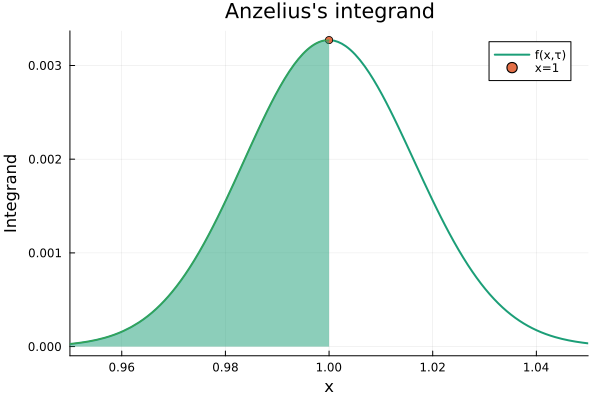

In [22]:
#| echo: false
#| label: fig-anz-int-2
#| fig-cap: "Integrating the Anzelius integrand on the interval <em>[0,1]</em>"
let
    plot( integrand, xlims=(0.95,1.05), label="f(x,τ)", color=colours[1], linestyle=:solid, lw=2)
    plot!( [1], [integrand(1)], seriestype=:scatter, lab="x=1")
    plot!( integrand, 0.95, 1, fill=(0, 0.5, colours[1]), lab=false)
    plot!( xlabel="x", ylabel="Integrand", title="Anzelius's integrand")
end

Because of my particular choice of *&tau;* the integral stops somewhere on the curve where it is appreciably positive. There is a potential trap here when using an integration routine with automatic step-sizes like Gauss-Kronold: if the bounds of integration extend well past the peak of this curve, it is possible for the algorithm to *step over it* entirely and return a value of 0, when the actual integral should be *~1*.

One way of dealing with this issue is to take advantage of the symmetry of the J function and use the following rule:[@lassey-1982 page 631]

+ for &xi;&le;&tau;, calculate $J \left( \xi, \tau \right)$ by direct numerical integration
+ for &xi;&gt;&tau;, calculate $J \left( \xi, \tau \right)$ by using the relation $$ J\left( \xi, \tau \right) = 1 + \exp\left( - \left( \sqrt{\tau} - \sqrt{\xi} \right)^2 \right) I_{x,0} \left( 2 \sqrt{\tau \xi} \right) - J\left( \tau, \xi \right) $$ where $J\left( \tau, \xi \right)$ is then numerically integrated

This ensures that the numerical integration is always being taken to the left of the peak of the integrand (where *&xi;* = *&tau;*) and thus avoids the stepping over problem.

In [23]:
#| output: false
using QuadGK: quadgk

function J_quad(x,y)
    if x ≈ 0
        return 1.0, 0.0
    elseif y ≈ 0
        return exp(-x), 0.0
    else
        integrand(λ) = exp(-(√(y)-√(x*λ))^2)*besseli0x(√(4y*x*λ))
        ∫, e = quadgk(integrand,0,1)
        J = 1.0 - x*∫
        return J, e
    end
end

function c_quad(t, model::AnzeliusSolution)
    # unpack some things, calculate model parameters
    cₛ = model.pb.q₀/model.pb.K
    c₀ = model.pb.c₀
    τ = model.τ₁*t - model.τ₂
    ξ = model.ξ

    # use Gause-Kronold to integrate
    # modified integral for τ < ξ from Lassey p. 631
    if τ < 0 || ξ < 0
    # outside the domain of the problem
        J = 0.0
    elseif ξ ≤ τ
        J, e = J_quad(ξ,τ)
    else # τ < ξ
        J, e = J_quad(τ,ξ)
        J = 1 + exp(-(√(τ)-√(ξ))^2)*besseli0x(√(4τ*ξ)) - J
    end
    
    # return back the concentration
    c = cₛ + (c₀ - cₛ)*J
    return c
end

c_quad (generic function with 1 method)

### Series Representations of the Anzelius J function

A brief review of the literature around the Anzelius J function will reveal a multitude of series representations. For example, Goldstein[@goldstein-1953 page 159] gives the following

$$ J(x,y) = 1 - \exp\left( - \left( \sqrt{x} - \sqrt{y} \right)^2 \right) \sum_{n=1}^{\infty} \left( x \over y \right)^{n \over 2} \exp \left( -2 \sqrt{xy} \right) \mathrm{I}_{n} \left( 2 \sqrt{xy} \right) $$

Na&iuml;vely implementing this, without the use of any techniques like Richardson acceleration, ends up requiring a large number of iterations to approach the performance of direct integration by Gauss-Kronold. Since each iteration involves calculating exponentially scaled Bessel functions of higher and higher order, this doesn't obviously lead to any improvement over direct numerical integration.

In [24]:
# Naively, just adding them up
using Bessels:besselix

function J_series(x,y,N)
    if x ≈ 0
        return 1.0
    elseif y ≈ 0
        return exp(-x)
    else
        α = 2√(x*y)
        η = √(x/y)
        partial_sum = 0.0
        for k in 1:N
            partial_sum += besselix(k,α)*η^k
        end
        J = 1 - exp(-(√(x)-√(y))^2)*partial_sum
        return J
    end
end

N = 900
u = J_series(ξ,τ,N)

@show u; @show N;

u = 0.5016355470840961
N = 900


An alternative approach from Bac&#774;lic&#769; *et al.*[@baclic-1997 page 114] removes the need to calculate higher order Bessel functions and, though it also requires a large number of iterations, each iteration is a simpler calculation and thus the algorithm could be faster overall. If you were going to roll out the J function in production code it would be worthwhile bench marking this against numerical integration with [QuadGK.jl](https://juliamath.github.io/QuadGK.jl/stable/).

In [25]:
#| output: false
function bac̆lić_sub_A(α₋₁,β₋₁,α₀,β₀,d₁,z,ε,max_iter)
    αₙ₋₂, βₙ₋₂ = α₋₁, β₋₁
    αₙ₋₁, βₙ₋₁ = α₀, β₀
    αₙ, βₙ = 0.0, 0.0
    dₙ = d₁
    for n in 1:max_iter
        αₙ = dₙ + (n/z)*αₙ₋₁ + αₙ₋₂
        βₙ = 1 + (n/z)*βₙ₋₁ + βₙ₋₂

        if βₙ > 1/ε
            return αₙ, βₙ, n
        else
            dₙ = dₙ*d₁
            αₙ₋₂, βₙ₋₂ = αₙ₋₁, βₙ₋₁
            αₙ₋₁, βₙ₋₁ = αₙ, βₙ
        end
    end
    return αₙ, βₙ, max_iter
end

bac̆lić_sub_A (generic function with 1 method)

In [26]:
#| output: false
function J_bac̆lić(x,y,ε=1e-9,max_iter=10^6)
    if x ≈ 0
        return 1.0
    elseif y ≈ 0
        return exp(-x)
    else
        z = √(x*y)
        α₋₁ = 0.0
        β₋₁ = 0.0
        β₀ = 0.5
        if y < x
            α₀ = 1.0
            d₁ = √(y/x)
            αₙ, βₙ, N = bac̆lić_sub_A(α₋₁,β₋₁,α₀,β₀,d₁,z,ε,max_iter)
            J = (αₙ/(2*βₙ))*exp(-(√(y)-√(x))^2)
        else
            α₀ = 0.0
            d₁ = √(x/y)
            αₙ, βₙ, N = bac̆lić_sub_A(α₋₁,β₋₁,α₀,β₀,d₁,z,ε,max_iter)
            J = 1.0 - (αₙ/(2*βₙ))*exp(-(√(y)-√(x))^2)
        end
        return J, ε, N
    end
end

J_bac̆lić (generic function with 3 methods)

In [27]:
u, e, N = J_bac̆lić(τ,ξ)

@show u; @show e; @show N;

u = 0.5016355471003766
e = 1.0e-9
N = 698


In [28]:
#| output: false
function c_bac̆lić(t, model::AnzeliusSolution)
    # unpack some things, calculate model parameters
    cₛ = model.pb.q₀/model.pb.K
    c₀ = model.pb.c₀
    τ = model.τ₁*t - model.τ₂
    ξ = model.ξ
    
    if τ < 0 || ξ < 0
        u = 0.0
    else
        u, err, N = J_bac̆lić(ξ,τ)
    end
    
    c = cₛ + (c₀ - cₛ)*u
    return c
end

c_bac̆lić (generic function with 1 method)

### Approximations to the Anzelius J Function

Thomas[^20] provides an asymptotic expansion of *J* which forms the basis for several approximations to the J function

[^20]: @thomas-1948 page 171. *Note:* Thomas gives this in terms of &phi; where $J(x,y) = 1 - \exp \left( -(x+y) \right)\phi(x,y)$

$$ J(x,y) \approx 1 - \frac{1}{2}\mathrm{erfc} \left( \sqrt{y} - \sqrt{x} \right) + \exp \left( -(x+y) \right) { \sqrt[4]{x} \over { \sqrt[4]{y} + \sqrt[4]{x} } } I_0 \left( 2\sqrt{xy} \right) + \ldots$$

Taking the first terms of the asymptotic expansion and the limit $I_{x,0}(z) \to \frac{1}{\sqrt{2\pi z} }$ as *z &rarr; &infin;*[^21]

[^21]: [NIST DLMF 10.30.4](https://dlmf.nist.gov/10.30#E4)

$$ J(x,y) \approx \frac{1}{2}\mathrm{erfc} \left( \sqrt{x} - \sqrt{y} \right) + { \exp \left( - \left( \sqrt{x} - \sqrt{y} \right)^2 \right) \over { 2\sqrt{\pi} \left( \sqrt{y} + \sqrt[4]{xy} \right) } }$$

In [29]:
using SpecialFunctions: erf, erfc

In [30]:
function J_approx(x,y)
    if x ≈ 0
        return 1.0
    elseif y ≈ 0
        return exp(-x)
    else
        return 0.5*(erfc(√(x)-√(y)) + exp(-(√(x)-√(y))^2)/(√(π)*(√(y)+(x*y)^0.25)))
    end
end

u = J_approx(ξ,τ)

@show u;

u = 0.5016355333390161


In [31]:
#| output: false
function c_approx(t, model::AnzeliusSolution)
    # unpack some things, calculate model parameters
    cₛ = model.pb.q₀/model.pb.K
    c₀ = model.pb.c₀
    τ = model.τ₁*t - model.τ₂
    ξ = model.ξ

    # approximate integral
    if τ < 0 || ξ < 0
        u = 0.0
    else
        u = J_approx(ξ,τ)
    end
        
    # return back the concentration
    c = cₛ + (c₀ - cₛ)*u
    return c
end

c_approx (generic function with 1 method)

Rice[@rice-1980 page 334] goes even further and suggests that, for $\sqrt{xy} \gt 60$

$$ J(x,y) \approx \frac{1}{2}\mathrm{erfc} \left( \sqrt{x} - \sqrt{y} \right) $$

In [32]:
function J_rice(x,y)
    if x ≈ 0
        return 1.0
    elseif y ≈ 0
        return exp(-x)
    else
        return 0.5*erfc(√(x)-√(y))
    end
end

u = J_rice(ξ,τ)

@show u;

u = 0.499999999999992


In [33]:
#| output: false
function c_rice(t, model::AnzeliusSolution)
    # unpack some things, calculate model parameters
    cₛ = model.pb.q₀/model.pb.K
    c₀ = model.pb.c₀
    τ = model.τ₁*t - model.τ₂
    ξ = model.ξ

    # approximate integral
    if τ < 0 || ξ < 0
        u = 0.0
    else
        u = 0.5*erfc(√(ξ)-√(τ))
    end
        
    # return back the concentration
    c = cₛ + (c₀ - cₛ)*u
    return c
end

c_rice (generic function with 1 method)

### Reviewing Overall Performance

I don't see any great reason to use anything other than direct numerical integration, so that is the default method I am going to set going forward.

In [34]:
#| output: false
c(t,m::AnzeliusSolution) = c_quad(t,m)

c (generic function with 1 method)

That said, for this particular case, the mass transfer across the thin film is so rapid that all of the approximations are close enough as to be indistinguishable. Indistinguishable to the naked eye when staring at a plot but, more importantly, experimentally indistinguishable.

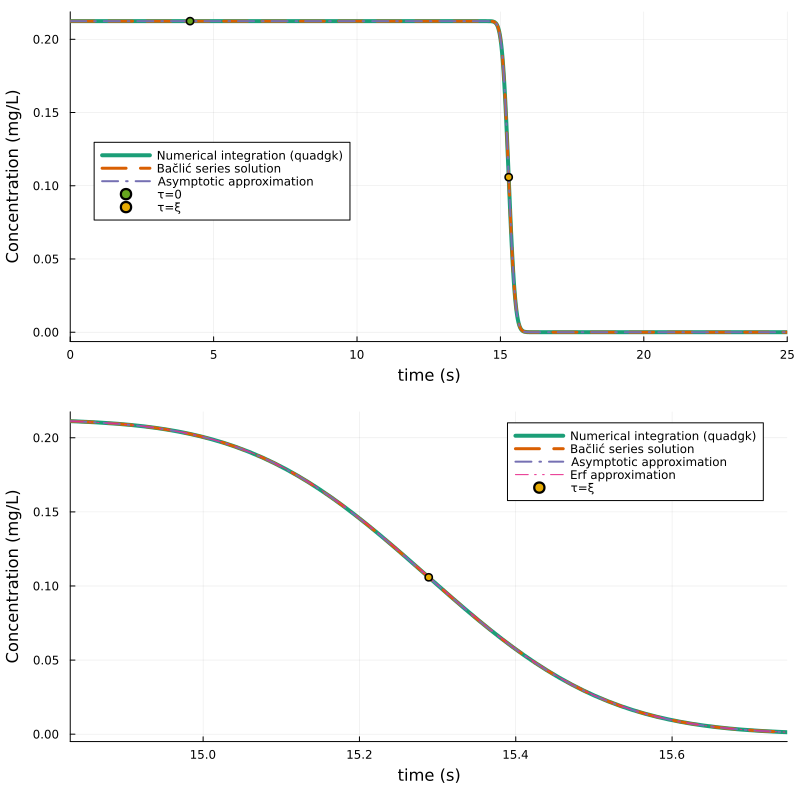

In [35]:
#| echo: false
#| label: fig-anz-conc
#| fig-cap: "The Anzelius solution and its approximations. For this problem the approximations are essentially exact."
let t=ustrip(t)

p1 = plot(t′ -> c_quad(t′*1u"s", anzelius)/1000, xlim=(0, 25), label="Numerical integration (quadgk)", color=colours[1], linestyle=:solid, lw=4)
plot!(p1, t′ -> c_bac̆lić(t′*1u"s", anzelius)/1000, xlim=(0,25), label="Bac̆lić series solution", color=colours[2], linestyle=:dash, lw=3)
plot!(p1, t′ -> c_approx(t′*1u"s", anzelius)/1000, xlim=(0,25), label="Asymptotic approximation", color=colours[3], linestyle=:dashdot, lw=2)
plot!(p1, [ustrip(z/v)], [c_sat/1000], seriestype=:scatter, label="τ=0", color=colours[5])
plot!(p1, [t], [c_quad(t*1u"s",anzelius)/1000], seriestype=:scatter, label="τ=ξ", color=colours[6])
plot!(p1, xlabel="time (s)", ylabel="Concentration (mg/L)", legend=:left)

p2 = plot(t′ -> c_quad(t′*1u"s", anzelius)/1000, xlim=(0.97*t, 1.03*t), label="Numerical integration (quadgk)", color=colours[1], linestyle=:solid, lw=4)
plot!(p2, t′ -> c_bac̆lić(t′*1u"s", anzelius)/1000, xlim=(0.97*t, 1.03*t), label="Bac̆lić series solution", color=colours[2], linestyle=:dash, lw=3)
plot!(p2, t′ -> c_approx(t′*1u"s", anzelius)/1000, xlim=(0.97*t, 1.03*t), label="Asymptotic approximation", color=colours[3], linestyle=:dashdot, lw=2)
plot!(p2, t′ -> c_rice(t′*1u"s", anzelius)/1000, xlim=(0.97*t, 1.03*t), label="Erf approximation", color=colours[4], linestyle=:dashdotdot, lw=1)
plot!(p2, [t], [c_quad(t*1u"s", anzelius)/1000], seriestype=:scatter, label="τ=ξ", color=colours[6])
plot!(p2, xlabel="time (s)", ylabel="Concentration (mg/L)")

plot(p1, p2, layout=@layout([°;°]), size=(800,800))
end

I wouldn't take this to mean that the simple, single term, $\mathrm{erfc}(\ldots)$ approximation will work for modelling an actual espresso shot, though it is certainly suggestive. This approach, neglecting the solid phase diffusion entirely and neglecting axial diffusion, has lead to a very sharp moving front that is physically unrealistic. What this model is telling us is that we should expect an espresso shot to start as fully and overly extracted coffee and, after some time, transition into essentially tap water in a fraction of a second. That is not my experience, qualitatively. What this shows is that we need to increase the complexity of the model.

## Rosen's Integral Solution

Rosen[@rosen-1952 pages 387-394] solved the problem for the case where solid diffusion is included, but axial diffusion is still neglected, in a similar manner as above with Laplace transforms. In this case actually solving the pde is more tedious and what follows is just a loose sketch. Starting with the pde

$$ { {\partial c} \over {\partial t} } + v { {\partial c} \over {\partial z} } = \left({ 1 - \varepsilon } \over \varepsilon \right) a_s J_s $$

$$ { {\partial q} \over {\partial t} } = \mathscr{D}_s \left( { {\partial^2 q} \over {\partial r^2} }  + {2 \over r} { {\partial q} \over {\partial r} }  \right) $$

were

$$ J_s = h \left( c_{s} -  c \right) $$

Rosen introduced
$$ { {\partial \bar{q} } \over {\partial t} } = - a_s J_s $$

where

$$ \bar{q} \left( z,t \right) = \frac{3}{b^3} \int_0^b q \left( r, \xi, \tau \right) r^2 dr $$

is the volumetric average concentration in a particle. This follows directly from a mass balance.

We can put the liquid phase equation in dimensionless form by introducing a dimensionless time, $\tau = { { \mathscr{D} a_s} \over b} \left( t - \frac{z}{v} \right)$, and a dimensionless z-coordinate, $\xi = { { K D a_s} \over {b m v} } z$, where $m = { \varepsilon \over \left( 1 - \varepsilon \right) }$ and, with the same dimensionless concentrations *u* and *y* as defined above for the Anzelius solution, we have

$$ { { \partial u} \over {\partial \xi} } = - { { \partial \bar{y} } \over {\partial \tau} } = \frac{1}{\nu} \left( y_s - u \right)$$

where $\nu = \frac{\mathscr{D} K}{b h}$ and *y<sub>s</sub>* is the dimensionless solid phase concentration at the surface of a solid particle, i.e. at *r = b*.

If we further introduce a dimensionless particle radius $\vartheta = \frac{r}{b}$ we can rewrite the solid phase diffusion equation in dimensionless form

$$ { {\partial y} \over {\partial \tau} } = \frac{1}{3} \left( { {\partial^2 y} \over {\partial \vartheta^2} }  + {2 \over \vartheta} { {\partial y} \over {\partial \vartheta} }  \right) $$

where *1/3* is *1/(a<sub>s</sub>b)*. The solution to the solid phase diffusion problem is available in Carslaw and Jaeger[@carslaw-1959 page 233] and, with initial condition *y=0* when *&tau;=0*, gives

$$ y \left( \vartheta, \xi, \tau \right) = \frac{2}{3} \sum_{n=1}^{\infty} \left(-1 \right)^{n+1} n\pi { {\sin \left( n \pi \vartheta \right) } \over \vartheta} \int_0^{\tau} y_s \left( \xi, \lambda \right) \exp \left( -\frac{n^2 \pi^2}{3} \left( \tau - \lambda \right) \right) d\lambda$$

This can be integrated over $\vartheta$ to get the volume average (dimensionless) concentration

$$ \bar{y} = 3 \int_0^1 y \vartheta^2 d \vartheta $$

$$ \bar{y} = 2 \sum_{n=1}^{\infty} \int_0^{\tau} y_s \exp \left( -\frac{n^2 \pi^2}{3}  \left( \tau - \lambda \right) \right) d\lambda $$

since

$$ \int_0^1 n\pi \sin \left( n \pi \vartheta \right) \vartheta d\vartheta = \left(-1 \right)^{n+1} $$

Taking the derivative with respect to *&tau;* gives (by integration by parts)

$$ { {\partial \bar{y} } \over {\partial \tau} } = 2 \sum_{n=1}^{\infty} \int_0^{\tau} { { \partial y_s } \over {\partial \lambda} } \exp \left( -\frac{n^2 \pi^2}{3} \left( \tau - \lambda \right) \right) d\lambda $$

At this point we can eliminate *y* and *y<sub>s</sub>* and have an expression entirely in terms of *u*. First we use the expression for the liquid phase concentration to obtain an expression for *y<sub>s</sub>*

$$ { { \partial u} \over {\partial \xi} } = \frac{1}{\nu} \left( y_s - u \right)$$

$$ y_s = u + \nu { { \partial u} \over {\partial \xi} } $$

Thus 

$$ { {\partial \bar{y} } \over {\partial \tau} } = 2 \sum_{n=1}^{\infty} \int_0^{\tau} \left[ { {\partial u} \over {\partial \lambda} } + \nu { { \partial^2 u} \over {\partial \lambda \partial \xi} } \right] \exp \left( -\frac{n^2 \pi^2}{3}  \left( \tau - \lambda \right) \right) d\lambda $$

and since ${ { \partial u} \over {\partial \xi} } = - { { \partial \bar{y} } \over {\partial \tau} }$

$$ { {\partial u } \over {\partial \xi} } = -2 \sum_{n=1}^{\infty} \int_0^{\tau} \left[ { {\partial u} \over {\partial \lambda} } + \nu { { \partial^2 u} \over {\partial \lambda \partial \xi} } \right] \exp \left( -\frac{n^2 \pi^2}{3} \left( \tau - \lambda \right) \right) d\lambda $$

Rosen solves this by taking the Laplace transform, with respect to *&tau;*, with the following relations:

$$ \mathscr{L} \left\{ \int_0^\tau f(\lambda) g(\tau-\lambda) d\lambda \right\} = F(s) G(s) $$

$$ \mathscr{L} \left\{ { {\partial u} \over {\partial \tau} } + \nu { { \partial^2 u} \over {\partial \tau \partial \xi} } \right\} =  s U + \nu s { {d U} \over {d\xi} }$$

$$ \mathscr{L} \left\{ \exp \left( -\frac{n^2 \pi^2}{3} \tau \right) \right\} =  { 1 \over {s + \frac{n^2 \pi^2}{3} } }$$

arriving at

$$ { {d U} \over {d\xi} } = -2 \left( s U + \nu s { {d U} \over {d\xi} } \right) \sum_{n=1}^{\infty} { s \over {s + \frac{n^2 \pi^2}{3} } } $$

Letting

$$ Y_D(s) = 2 \sum_{n=1}^{\infty} { s \over {s + \frac{n^2 \pi^2}{3} } } $$

then

$$ { {d U} \over {d\xi} } = - { Y_D \over  { 1 + \nu Y_D } } U $$

and, solving this ode with initial condition *u=1*, *U=1/s*, gives

$$ U = \frac{1}{s} \exp \left( - { Y_D \over  { 1 + \nu Y_D } } \xi \right) $$

The final solution follows from taking the inverse Laplace transform, by way of the [contour integral](https://en.wikipedia.org/wiki/Inverse_Laplace_transform#Mellin's_inverse_formula)

$$ u \left( \xi, \tau \right) = \frac{1}{2\pi i} \int_{\alpha - i\infty}^{\alpha + i\infty} \frac{1}{s} \exp \left( s \tau - { Y_D \over  { 1 + \nu Y_D } } \xi \right) ds $$

A major component of the integration involves first defining *Y<sub>D</sub>* in terms of trigonometric functions. The details are tedious, but the main result is

$$ Y_T \left( i \beta \right) = { Y_D \over  { 1 + \nu Y_D } } = H_1 \left( \lambda, \nu \right) + i H_2 \left( \lambda, \nu \right) $$

with $\lambda = \sqrt{ \frac{3}{2} \beta}$ and

$$ H_1 \left( \lambda, \nu \right) = { { H_{D1} + \nu \left( H_{D1}^2 + H_{D2}^2 \right) } \over { \left( 1 + \nu H_{D1} \right)^2 + \left( \nu H_{D2} \right)^2 } }$$

$$ H_2 \left( \lambda, \nu \right) = { H_{D2} \over { \left( 1 + \nu H_{D1} \right)^2 + \left( \nu H_{D2} \right)^2 } }$$

and

$$ H_{D1} = \lambda { {\sinh 2\lambda + \sin 2\lambda} \over { \cosh 2\lambda - \cos 2\lambda } } - 1$$

$$ H_{D2} = \lambda { {\sinh 2\lambda - \sin 2\lambda} \over { \cosh 2\lambda - \cos 2\lambda } } $$

Which allows Rosen to write the integral in terms of these harmonic functions[^25]

$$ u \left( \xi, \tau \right) = \frac{1}{2} + \frac{2}{\pi} \int_0^\infty { { \exp \left( -\xi H_1 \left( \lambda, \nu \right) \right) \sin \left( \frac{2}{3} \tau \lambda^2 - \xi H_2 \left( \lambda, \nu \right) \right) } \over \lambda } d\lambda $$

[^25]: For details of the integration see @rosen-1952 pages 390-391

### Defining the Rosen Solution

At this point we can calculate the dimensionless space and time for a point at the exit of the espresso bed, and say at a similar point in (dimensionless) time, and proceed with calculating the integral to find the concentration.

In [36]:
m = ε/(1-ε)
aᵥ = 3/b

ξ = (K*𝒟ₛ*aᵥ)/(b*m*v)*z

τ = (𝒟ₛ*aᵥ/b)*(t-z/v)
ν = (𝒟ₛ*K)/(b*h)

@show ξ; @show τ; @show ν;

ξ = 144.6719346388569
τ = 144.6719346388569
ν = 0.019452389057107278


Unlike with the Anzelius case, I am not going to define a struct for the Rosen solution yet, first I am going to work through some details on how to perform the integral.

### The Harmonic Functions

The integral extends to infinity and so the performance of the harmonic functions at very large *&lambda;* is important. The hyperbolic trig functions will blow up to infinity and, in the na&iuml;ve implementation, lead to `NaN` errors as the numerator and denominator overflow. Rosen provides limiting behaviour, and a pre-calculated table of values, which can be used with the integrand switching from the default definition of the harmonic functions to the limiting behaviour after some *&lambda;* threshold. An alternative, which I employ below, is to rewrite the hyperbolic trig functions in terms of exponentials,  cancelling a *exp(+4&lambda;)* from the numerator and denominator, to generate a form that handles large values of *&lambda;* more gracefully.

$$ { {\sinh 2\lambda + \sin 2\lambda } \over {\cosh 2\lambda - \cos 2\lambda} } = { { 1 - \exp(-2\lambda) \left( \exp(-2\lambda) + 2 \sin 2\lambda \right) } \over {1 + \exp(-2\lambda) \left( \exp(-2\lambda) - 2 \cos 2\lambda \right) } }$$

In [37]:
#| output: false
function HD1(λ)
    if λ ≤ eps(0.0)
        return 0.0
    else
        # λ*((sinh(2λ) + sin(2λ))/(cosh(2λ) - cos(2λ))) - 1
        return λ*( (1 - exp(-4λ) + 2*exp(-2λ)*sin(2λ)) / (1 + exp(-4λ) - 2*exp(-2λ)*cos(2λ))) -1 
    end
end

function HD2(λ)
    if λ ≤ eps(0.0)
        return 0.0
    else
        # λ*(sinh(2λ) - sin(2λ))/(cosh(2λ) - cos(2λ))
        return λ*( (1 - exp(-4λ) - 2*exp(-2λ)*sin(2λ)) / (1 + exp(-4λ) - 2*exp(-2λ)*cos(2λ))) 
    end
end

HD2 (generic function with 1 method)

### Integration by Gauss-Kronold

The integrand can be divided into a decay component, *f*, that is independent of *&tau;*, and an oscillatory component, *K*, that is a function of *&tau;*. 

$$ f \left( \lambda; \xi, \nu \right) = { { \exp \left( -\xi H_1 \left( \lambda, \nu \right) \right) } \over \lambda  }$$

$$ \mathscr{K} \left( \lambda, \tau; \xi, \nu \right) = \sin \left( \frac{2}{3} \tau \lambda^2 - \xi H_2 \left( \lambda, \nu \right) \right) $$

This clean division also presents an opportunity to pre-calculate the integral to an extent. With a predefined set of points *{ &lambda;<sub>i</sub> }* then *f* can be entirely pre-calculated. Using [prosthaphaeresis](https://mathworld.wolfram.com/ProsthaphaeresisFormulas.html) you could go further and pre-calculate parts of $\mathscr{K}$, for some incremental improvements, though I leave that as an exercise for a more motivated individual.

It is worth looking at the case where *&tau;* gets large as this becomes a highly oscillating integral and can be tricky to evaluate -- requiring a very large number of steps for conventional numerical integration techniques like Gauss-Kronold. In this example that starts to happen near the end of the extraction, but if the bed were, say, twice as deep then much of the extraction curve would be in this regime.

In [38]:
#| output: false
function fᵣ(λ; ξ, ν)
    hd1, hd2 = HD1(λ), HD2(λ)
    H1 = (hd1 + ν*(hd1^2 + hd2^2))/((1 + ν*hd1)^2 + (ν*hd2)^2)
    return exp(-ξ*H1)/λ
end

function 𝒦ᵣ(λ, τ; ξ, ν)
    hd1, hd2 = HD1(λ), HD2(λ)
    H2 = hd2/((1 + ν*hd1)^2 + (ν*hd2)^2)
    return sin((2/3)*τ*λ^2 - ξ*H2)
end

𝒦ᵣ (generic function with 1 method)

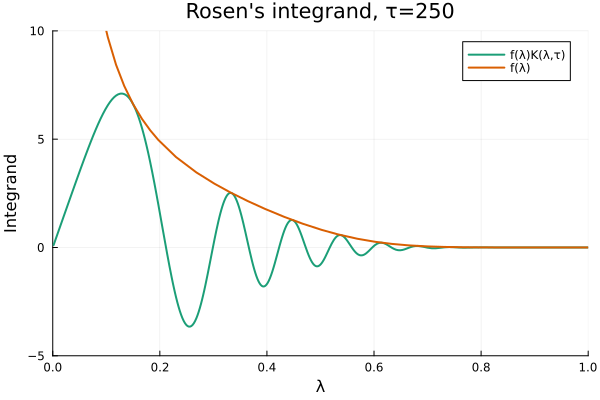

In [39]:
#| echo: false
#| label: fig-rosen-integrand
#| fig-cap: "The integrand of the Rosen solution, for moderate values of <em>&tau;</em> this is a highly oscillating integral."

let τ = 250
    plot( x -> fᵣ(x; ξ=ξ, ν=ν)*𝒦ᵣ(x, τ; ξ=ξ, ν=ν), xlims=(0, 1), label="f(λ)K(λ,τ)", color=colours[1], linestyle=:solid, lw=2)
    plot!( x -> fᵣ(x; ξ=ξ, ν=ν), xlims=(0, 1), label="f(λ)", color=colours[2], linestyle=:solid, lw=2)
    plot!( xlabel="λ", ylabel="Integrand", title="Rosen's integrand, τ=$(round(τ))", ylims=(-5,10))
end

By introducing the change of variables[@rosen-1954 pages 1590-1594] *&beta; = &lambda;<sup>2</sup>*, the integrand is "compressed" along *&beta;* and we can take advantage of the exponential decay to truncate the integration.

In [40]:
#| output: false
function fᵣ₂(β; ξ, ν)
    λ = √(β)
    hd1, hd2 = HD1(λ), HD2(λ)
    H1 = (hd1 + ν*(hd1^2 + hd2^2))/((1 + ν*hd1)^2 + (ν*hd2)^2)
    return exp(-ξ*H1)/β
end

function 𝒦ᵣ₂(β, τ; ξ, ν)
    λ = √(β)
    hd1, hd2 = HD1(λ), HD2(λ)
    H2 = hd2/((1 + ν*hd1)^2 + (ν*hd2)^2)
    return sin((2/3)*τ*β - ξ*H2)
end

𝒦ᵣ₂ (generic function with 1 method)

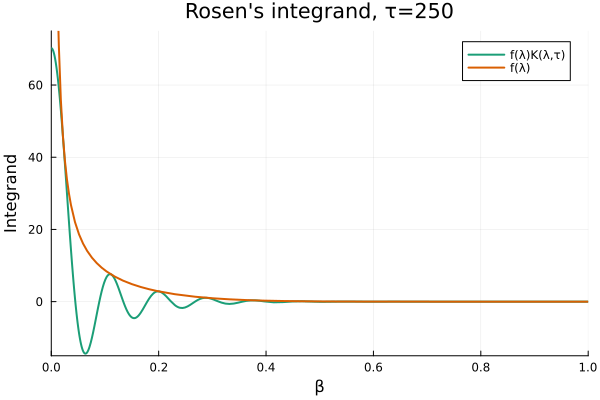

In [41]:
#| echo: false
#| label: fig-rosen-int-2
#| fig-cap: "The integrand of the Rosen solution, after the change of variables. The curve decays much more rapidly."

let τ = 250
    plot( x -> fᵣ₂(x; ξ=ξ, ν=ν)*𝒦ᵣ₂(x, τ; ξ=ξ, ν=ν), xlims=(0, 1), label="f(λ)K(λ,τ)", color=colours[1], linestyle=:solid, lw=2)
    plot!( x -> fᵣ₂(x; ξ=ξ, ν=ν), xlims=(0, 1), label="f(λ)", color=colours[2], linestyle=:solid, lw=2)
    plot!( xlabel="β", ylabel="Integrand", title="Rosen's integrand, τ=$(round(τ))", ylims=(-15,75))
end

[QuadGK.jl](https://juliamath.github.io/QuadGK.jl/stable/) can compute the improper integral directly, by making the substitution *&lambda; = t/(1-t)*.

In [42]:
using QuadGK: quadgk_count

I₁, err₁, N₁ = quadgk_count(λ -> fᵣ(λ; ξ=ξ, ν=ν)*𝒦ᵣ(λ, τ; ξ=ξ, ν=ν), 0, Inf)

@show I₁; @show err₁; @show N₁;

I₁ = 0.011703238397164204
err₁ = 1.0292584595556625e-10
N₁ = 195


By making the substitution *&beta; = &lambda;<sup>2</sup>* and truncating the integral to the range *[0,2]* we can achieve similar precision, with almost half as many steps.

In [43]:
I_2, err_2, N_2 = quadgk_count( β -> fᵣ₂(β; ξ=ξ, ν=ν)*𝒦ᵣ₂(β, τ; ξ=ξ, ν=ν), 0, 2)

@show I_2/2; @show err_2; @show N_2;

I_2 / 2 = 0.01170323839564812
err_2 = 2.183245425172356e-10
N_2 = 105


### Integration by Levin Colocation

I have mentioned a few times that highly oscillating integrals can be tricky to evaluate. Gaussian quadrature will, in general, work but it will require a large number of steps. An alternative is to use Levin colocation, an example implementation is given below using [ApproxFun.jl](https://juliaapproximation.github.io/ApproxFun.jl/latest/).

Given the integral

$$ \int_a^b \mathbf{f}(x) \cdot \mathbf{K}(x) dx $$

if we suppose there is a function $\mathbf{F}$ such that

$$ \frac{d}{dx} \mathbf{F}(x) \cdot \mathbf{K}(x) = \mathbf{f}(x) \cdot \mathbf{K}(x) $$

Then we can eliminate the integral, using the fundamental theorem of calculus

$$ \int_a^b \mathbf{f}(x) \cdot \mathbf{K}(x) dx = \int_a^b \frac{d}{dx} \mathbf{F}(x) \cdot \mathbf{K}(x) dx = \mathbf{F}(b) \cdot \mathbf{K}(b) - \mathbf{F}(a) \cdot \mathbf{K}(a)$$

The problem is then one of finding the function $\mathbf{F}$. 

If we choose $\mathbf{K}(x)$ such that $\frac{d}{dx} \mathbf{K}(x) = \mathbf{A} \mathbf{K}(x)$, then

$$ \frac{d}{dx} \left( \mathbf{F}(x) \cdot \mathbf{K}(x) \right) =  \mathbf{F}^{\prime}(x) \cdot \mathbf{K}(x) + \mathbf{F}(x) \cdot \mathbf{A} \mathbf{K}(x) $$

$$ \mathbf{F}^{\prime}(x) \cdot \mathbf{K}(x) + \mathbf{F}(x) \cdot \mathbf{A} \mathbf{K}(x) = \mathbf{f}(x) \cdot \mathbf{K}(x) $$

Eliminating **K**(x) gives

$$ \mathbf{F}^{\prime}(x) + \mathbf{A}^{T} \mathbf{F}(x) = \mathbf{f}(x) $$

Solving this ode then gives the final solution.

In this case I set **K**(x) to

$$ \mathbf{K}(x) = \begin{pmatrix} \sin(h(x) \\ \cos(h(x)) \end{pmatrix} $$

where *h(x) = (2/3)&tau;x<sup>2</sup> - &xi;H<sub>2</sub>(&lambda;)*, and **f**(x) is

$$ \mathbf{f}(x) = \begin{pmatrix} f(x) \\ 0 \end{pmatrix} $$

and the ode is solved for **F** in terms of [Chebyshev polynomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials).

In [44]:
#| output: false
using ApproxFun:Interval, Fun, Derivative, Evaluation, \, I
using LinearAlgebra: ⋅

function levin(ξ, τ, ν, a, b)
    d = Interval(a,b)
    λ = Fun(d)
    D = Derivative(d)
    E = Evaluation(a)

    HD1 = λ*(sinh(2λ) + sin(2λ))/(cosh(2λ) - cos(2λ)) - 1
    HD2 = λ*(sinh(2λ) - sin(2λ))/(cosh(2λ) - cos(2λ))
    
    H1 = (HD1 + ν*(HD1^2 + HD2^2))/((1 + ν*HD1)^2 + (ν*HD2)^2)
    H2 = HD2/((1 + ν*HD1)^2 + (ν*HD2)^2)

    h = (2/3)*τ*λ^2 - ξ*H2
    h′ = D*h
    w⃗ = [ sin(h); cos(h) ]
    
    f = exp(-ξ*H1)/λ
    f⃗ = [ 0; 0; f; 0 ]
    
    L = [ E    0;
          0    E;
          D    -h′*I;
          h′*I  D ]
    
    F = L\f⃗
    
    return F(b)⋅w⃗(b) - F(a)⋅w⃗(a)
end

levin (generic function with 1 method)

In [45]:
levin(ξ, τ, ν, 0.0001, 2)

0.011703248012960965

This works well enough, though there is a complication in that there is a singularity at *x=0*, it is also rather slow.

If the system of interest was consistently at large values of *&tau;*, where it is a highly oscillating integral throughout the main part of the problem domain, it would be worth looking at techniques to eliminate the singularity and speed it up. I include it here mostly for completeness. It is by delightful coincidence alone that I can get by solving *this particular* problem using more conventional numerical integration techniques.

### Pre-calculating the spatial component

As I mentioned above, by splitting the integral into a function *f* that depends only on space and a function *K* that is a function of time and space, we can pre-calculate all of the space dependent components and write the integral as a weighted sum.

$$ \int_a^b f \left(x; p\right) \mathcal{K} \left(x, t; p\right) dx \approx \sum_i^{N} w_i \mathcal{K}\left(x_i, t\right)$$

The obvious way to do this is to use [QuadGK.jl](https://juliamath.github.io/QuadGK.jl/stable/weighted-gauss/#Arbitrary-weight-functions) to take the weight function *f* and generate points that way. For example:

```julia
pts, wts = gauss( x -> fᵣ₂(x; ξ=ξ, ν=ν), 20, 0, 2);
```

I could not get this to work reliably, it would routinely run aground on `DomainErrors` close to the singularity at *x=0*. When I did get it to work it took a *very long time* to generate points, like leave my desk and go make coffee and maybe it will be done when I get back *long time*. I think if you really wanted to invest the time, and evaluating this integral was going to be in production code, it would be worth investigating a better quadrature rule since, when it does work, it allows you to use significantly fewer points in each integration.

The alternative, which works well enough for my purposes, is to use the `gauss` function to generate a set of points and weights in the truncated range $\beta \in [0,2]$ and then pre-calculate the values of *f* over those points. The final integral is then the weighted sum. This involves calculating far more points for any given integral, but it is much faster than either Levin colocation or trying to have QuadGK generate the weights.

In [46]:
using QuadGK: gauss

pts, wts = gauss(N₁, 0, 2);

wts = wts .* fᵣ₂.(pts; ξ=ξ, ν=ν);

I_gauss = sum( wts .* 𝒦ᵣ₂.(pts, τ; ξ=ξ, ν=ν) )/2

0.011703238395545075

This can be packaged neatly into an `IntegralTransform` struct that, when constructed, generates the set of points and appropriate weights such that it only the kernel function actually needs to be evaluated for any given time.

In [47]:
#| output: false
struct IntegralTransform{T}
    a::T
    b::T
    params::NamedTuple
    numpts::Integer
    pts::Vector{T}
    wts::Vector{T}
    kern::Function
end 

function IntegralTransform(params, fun, kern; a=0.0, b=2.0, numpts=350)
    pts, wts = gauss(numpts, a, b)
    wts = wts .* fun.(pts; params...)
    return IntegralTransform(a, b, params, numpts, pts, wts, kern)
end

function integrate(t, it::IntegralTransform)
    return sum( it.wts .* it.kern.(it.pts, t; it.params...) )
end

integrate (generic function with 1 method)

One could go further here: pre-calculating *H<sub>1</sub>* and *H<sub>2</sub>* as they only depend on *&nu;* and *&lambda;*, splitting *K* into parts by [prosthaphaeresis](https://en.wikipedia.org/wiki/Prosthaphaeresis)[^27] and pre-calculating the parts that only depend on *&xi;* and *&lambda;*. The current performance is more than good enough for me, but I think it worth highlighting that there are many opportunities for improvement.

[^27]: I love this word.

### Packaging a final approach

At this point I am finally ready to circle back and create my `RosenSolution` struct, one that includes the pre-calculated `IntegralTransform` for the particular location in the bed.

In [48]:
#| output: false
struct RosenSolution{Q1,Q2,T}
    τ₁::Q1
    τ₂::Q2
    pb::PackedBed
    it::IntegralTransform{T}
end

function RosenSolution(z, pb::PackedBed; fun=fᵣ₂, kern=𝒦ᵣ₂, a=0.0, b=2.0, numpts=200)
    m = pb.ε/(1-pb.ε)
    aᵥ = 3/pb.b
    ξ = (pb.K*pb.𝒟ₛ*aᵥ*z)/(m*pb.v*pb.b)
    ν = (pb.𝒟ₛ*pb.K)/(pb.b*pb.h)
    τ₁ = pb.𝒟ₛ*aᵥ/pb.b
    τ₂ = τ₁*(z/pb.v)

    p = (ξ=ξ, ν=ν)
    it = IntegralTransform(p, fun, kern; a=a, b=b, numpts=numpts)
    
    return RosenSolution(τ₁, τ₂, pb, it)
end

RosenSolution

The concentration can then be obtained by calling the `integrate` function with the integral transform.

In [49]:
#| output: false
function c(t, model::RosenSolution)
    # unpack some things
    cₛ = model.pb.q₀/model.pb.K
    c₀ = model.pb.c₀

    # compute the integral
    τ = model.τ₁*t - model.τ₂
    I = integrate(τ, model.it)

    # return back the concentration
    u = 0.5 + I/π
    c = cₛ + (c₀ - cₛ)*u
    return c
end

c (generic function with 2 methods)

In [50]:
rosen = RosenSolution(z, pb; a=0.0, b=2.0, numpts=200);

### Approximations to the Rosen Integral

Rosen[@rosen-1954 page 1591] provides an asymptotic approximation for cases where *&xi;* is large

$$ u = \frac{1}{2} \left[ 1 + \mathrm{erf} \left( { { \frac{\tau}{\xi} - 1} \over { 2 \sqrt{ {1 + 5\nu} \over {5 \xi} } } } \right) \right] $$

Which is decidedly simpler to calculate.

In [51]:
#| output: false
function c_approx(t, model::RosenSolution)
    # unpack some things
    cₛ = model.pb.q₀/model.pb.K
    c₀ = model.pb.c₀

    # compute the integral
    τ = model.τ₁*t - model.τ₂
    u = 0.5*(1 + erf( ( (τ/ξ) - 1 ) / ( 2*√((1+5ν)/(5ξ)) ) ) )

    # return back the concentration
    c = cₛ + (c₀ - cₛ)*u
    return c
end

c_approx (generic function with 2 methods)

### Approximating the Rosen integral with the Anzelius J Function

I briefly mentioned, above, an effective mass transfer coefficient can be derived for the Anzelius solution, one that accounts for the solid phase diffusion. This can be calculated rather simply from the linear resistance model[@levan-2008 16-24]


$$ \frac{1}{h_{eff} } = \frac{1}{(1-\varepsilon) h} + \frac{b}{5 K \mathscr{D}_s} $$

Adapting the `AnzeliusSolution` to use a generic function to calculate the effective mass transfer coefficient allows us to reuse everything from the Anzelius case.

In [52]:
#| output: false
function AnzeliusSolution(z, h_fun, pb::PackedBed)
    m  = pb.ε/(1-pb.ε) 
    aᵥ = 3/pb.b
    h  = h_fun(pb)
    ξ  = (h*aᵥ*z)/(m*pb.v)
    τ₁ = (h*aᵥ/pb.K)
    τ₂ = τ₁*(z/pb.v)

    return AnzeliusSolution(ξ, τ₁, τ₂, pb)
end

h_eff(pb) = 1/( 1/((1-pb.ε)*pb.h) + pb.b/(5*pb.K*pb.𝒟ₛ) )

h_eff (generic function with 1 method)

### Reviewing Overall Performance

The Rosen solution is a significant departure from the pure Anzelius solution, i.e. neglecting solid diffusion, showing that for this problem the rate of solid phase diffusion is quite important. In this case *&xi;* is large enough that the asymptotic approximation to Rosen's integral is also a very good model and, with an appropriate effective mass transfer coefficient, the Anzelius solution also works well.

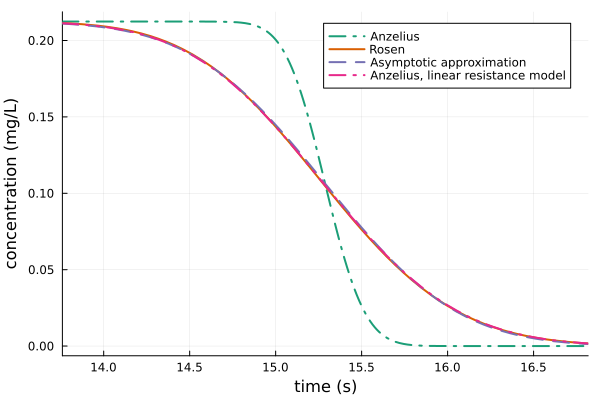

In [53]:
#| echo: false
#| label: fig-rosen-conc
#| fig-cap: "The Rosen solution, and it's approximations, compared with the Anzelius solution. Note the approximations are essentially exact for this problem."

let t = ustrip(t), anz_eff = AnzeliusSolution(z, h_eff, pb)
δ = 0.10
Δx = (1-δ,1+δ).*t
p1 = plot()
plot!(p1, t′ -> c(t′*1u"s", anzelius)/1000, xlim=Δx, label="Anzelius", color=colours[1], linestyle=:dashdot, lw=2)
plot!(p1, t′ -> c(t′*1u"s", rosen)/1000, xlim=Δx, label="Rosen", color=colours[2], linestyle=:solid, lw=2)
plot!(p1, t′ -> c_approx(t′*1u"s", rosen)/1000, xlim=Δx, label="Asymptotic approximation", color=colours[3], linestyle=:dash, lw=2)
plot!(p1, t′ -> c(t′*1u"s", anz_eff)/1000, xlim=Δx, label="Anzelius, linear resistance model", color=colours[4], linestyle=:dashdotdot, lw=2)

plot!(p1, xlabel="time (s)", ylabel="concentration (mg/L)", legend=:topright)
plot(p1)
end

## Rasmuson's Integral Solution

Rasmuson and Neretnieks[@rasmuson-1980 pages 686-690] provide an exact solution for the case where axial diffusion is included. This is the original pde derived at the beginning. Their solution follows essentially the same steps as Rosen, with the main difference that the ode in the Laplace domain is second order, due to the inclusion of the $\frac{\partial^2 c}{\partial z^2}$ term. The original paper has an detailed derivation in the appendix, if you are interested. In practice, this amounts to a relatively minor modification on what we have already put together for the Rosen solution.

First we define the decay function, *f*, and kernel, *K*, using the same harmonic functions as Rosen.

In [54]:
#| output: false
function f_rasmuson(λ; ν, δ, R, Pe)
    hd1, hd2 = HD1(λ), HD2(λ)
    H1 = (hd1 + ν*(hd1^2 + hd2^2))/((1 + ν*hd1)^2 + (ν*hd2)^2)
    H2 = hd2/((1 + ν*hd1)^2 + (ν*hd2)^2)
    a = Pe*(0.25*Pe + δ*H1)
    b = δ*Pe*((2/3)*λ^2/R + H2)
    return exp(0.5*Pe - √(0.5*(√(a^2 + b^2) + a)))/λ
end

function 𝒦_rasmuson(λ, y; ν, δ, R, Pe)
    hd1, hd2 = HD1(λ), HD2(λ)
    H1 = (hd1 + ν*(hd1^2 + hd2^2))/((1 + ν*hd1)^2 + (ν*hd2)^2)
    H2 = hd2/((1 + ν*hd1)^2 + (ν*hd2)^2)
    a = Pe*(0.25*Pe + δ*H1)
    b = δ*Pe*((2/3)*λ^2/R + H2)
    return sin(y*λ^2 - √(0.5*(√(a^2 + b^2) - a)))
end

𝒦_rasmuson (generic function with 1 method)

Rasmuson and Neretnieks parameterize things slightly differently, and add some extra dimensionless groups due to the $\mathscr{D}_L$, but the result a similar sort of integral problem as Rosen, namely integrating a highly oscillating integral that decays rapidly.

In [55]:
#| output: false
γ = 3*𝒟ₛ*K/b^2
δ = γ*z/(m*v)
ν = γ*b/(3h)
σ = 2*𝒟ₛ/b^2

R = K/m
Pe = (z*v)/𝒟ₗ
y = σ*t

132.71388046690237

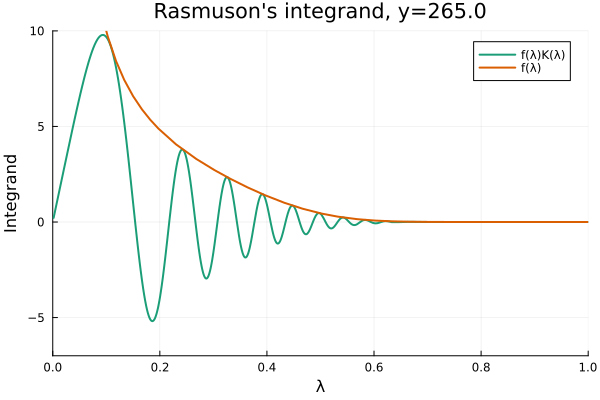

In [56]:
#| echo: false
#| label: fig-rasmuson
#| fig-cap: "The integrand of the Rasmuson-Neretnieks solution, for moderate values of <em>y</em> this becomes a highly oscillating integral."

let
    plot( x -> f_rasmuson(x; ν=ν, δ=δ, R=R, Pe=Pe)*𝒦_rasmuson(x, 2y; ν=ν, δ=δ, R=R, Pe=Pe), xlims=(0, 1), label="f(λ)K(λ)", color=colours[1], linestyle=:solid, lw=2)
    plot!( x -> f_rasmuson(x; ν=ν, δ=δ, R=R, Pe=Pe), xlims=(0, 1), label="f(λ)", color=colours[2], linestyle=:solid, lw=2)
    plot!( xlabel="λ", ylabel="Integrand", ylims=(-7,10), title="Rasmuson's integrand, y=$(round(2y))")
end

Thus it can be represented using the `IntegralTransform` type previously created.

In [57]:
p = (ν=ν, δ=δ, R=R, Pe=Pe)

it = IntegralTransform(p, f_rasmuson, 𝒦_rasmuson; a=0.0, b=2.0, numpts=200);

In [58]:
integrate(y, it)

0.011984085774006418

In [59]:
#| output: false
struct RasmusonSolution{Q,T}
    σ::Q
    pb::PackedBed
    it::IntegralTransform{T}
end

function RasmusonSolution(z, pb::PackedBed; fun=f_rasmuson, kern=𝒦_rasmuson, a=0.0, b=2.0, numpts=350)
    m = pb.ε/(1-pb.ε)
    γ = 3*pb.𝒟ₛ*pb.K/pb.b^2
    δ = γ*z/(m*pb.v)
    ν = γ*pb.b/(3*pb.h)
    σ = 2*pb.𝒟ₛ/pb.b^2
    
    R = pb.K/m
    Pe = (z*pb.v)/pb.𝒟ₗ

    p = (ν=ν, δ=δ, R=R, Pe=Pe)
    it = IntegralTransform(p, fun, kern; a=a, b=b, numpts=numpts)
    
    return RasmusonSolution(σ, pb, it)
end

RasmusonSolution

In [60]:
rasmuson = RasmusonSolution(z,pb);

In [61]:
#| output: false
function c(t, model::RasmusonSolution)
    # unpack some things
    cₛ = model.pb.q₀/model.pb.K
    c₀ = model.pb.c₀

    # compute the integral
    y = model.σ*t
    I = integrate(y, model.it)

    # return back the concentration
    u = 0.5 + 2I/π
    c = cₛ + (c₀ - cₛ)*u
    return c
end

c (generic function with 3 methods)

Going from Rosen's solution to Rasmuson's solution is a less dramatic change than from Anzelius, but it is clear that axial dispersion is an important effect in this case. I haven't shown it, since I think it should be obvious at this point, but one could generate asymptotic relations for Rasmuson, and also find effective mass transfer coefficients, *h*, that would bring *both* the Rosen and Anzelius solutions in line with the Rasmuson solution. I leave that as an exercise for the reader (hint: it is just linear mass transfer resistances).

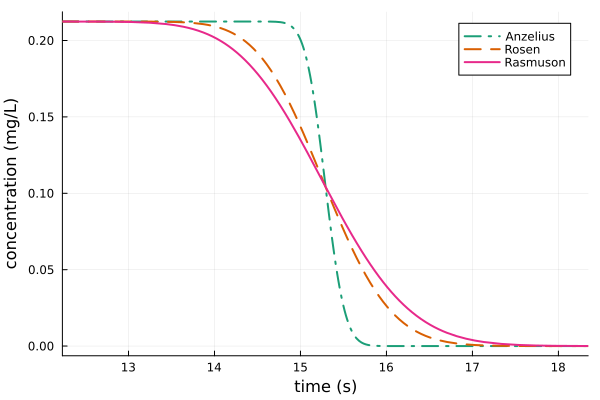

In [62]:
#| echo: false
#| label: fig-rasm-conc
#| fig-cap: "The Rasmuson-Neretnieks solution for packed bed extraction, compared with the Rosen and Anzelius cases."

let t=ustrip(t)
δ = 0.20
Δx = (1-δ,1+δ).*t
p1 = plot()
plot!(p1, t -> c(t*1u"s", anzelius)/1000, xlim=Δx, label="Anzelius", color=colours[1], linestyle=:dashdot, lw=2)
plot!(p1, t -> c(t*1u"s", rosen)/1000, xlim=Δx, label="Rosen", color=colours[2], linestyle=:dash, lw=2)
plot!(p1, t -> c(t*1u"s", rasmuson)/1000, xlim=Δx, label="Rasmuson", color=colours[4], linestyle=:solid, lw=2)
plot!(p1, xlabel="time (s)", ylabel="concentration (mg/L)", legend=:topright)
plot(p1)
end

## Integrating the PDE by finite difference

The more direct approach, when faced with a pde, is to integrate it by finite differences or [Method of Lines](https://en.wikipedia.org/wiki/Method_of_lines). This allows one to use whatever kinetics and initial conditions one wants. The above cases are all limited by linear extraction and the initial conditions that the bed is at equilibrium. The major downside is that, for problems like this with a rather sharp moving front, the discretization needs to be very tight or another method, like moving finite element, needs to be used. Thus making the actual run time rather slow.

The first step is to put the pde in dimensionless form, by introducing the following variables

$$ \xi = \frac{z}{L} $$

$$ \vartheta = \frac{r}{b} $$

$$ \tau = \frac{t}{t_{shot} } $$

$$ u = \frac{c}{c_{sat} }$$

$$ y = \frac{q}{q_{0} } $$

we can write the pde for the liquid phase concentration as

$$ { {\partial u} \over {\partial \tau} } = { { t_{shot} \mathscr{D}_L } \over L^2 } { {\partial^2 u} \over {\partial \xi^2} } - { {t_{shot} v} \over L }{ {\partial u} \over {\partial \xi} } - { {1 - \varepsilon} \over \varepsilon } h a_s t_{shot} \left( u - y \right)$$

and the pde for the solid phase concentration as

$$ { {\partial y} \over {\partial \tau} } = { {t_{shot} \mathscr{D}_s}  \over b^2 } \left( { {\partial^2 y} \over {\partial \vartheta^2} } + \frac{2}{\vartheta} { {\partial y} \over {\partial \vartheta} } \right) $$

with

$$ \left. { {\partial y} \over {\partial \tau} } \right\vert_{\vartheta=1} = { {h a_s t_{shot} } \over K} \left( u - y \right) $$

These equations can be discretized in both spatial dimensions *&xi;* and $\vartheta$, turning them into an ode in *&tau;*.

::: {#fig-discrete}


A discretized mass transfer system, the column is divided into <em>n</em> thin slices and each slice is further subdivided into <em>m+1</em> cells.
:::

In general the bed can be divided into *n* cells with each cell transferring fluid to the cell below by advection and exchanging mass with the solid phase through the thin film approximation. The solid phase would then be divided into *m* cells *per cell of the column* making the overall ode an *n&times;(m+1)* vector of cells.

### The Anzelius Example Case

As an example of the how tight the discretization needs to be, I have implemented the simple Anzelius case using an effective mass transfer coefficient. This is equivalent to the pde for the Rosen model, but with the solid phase mass transfer incorporated into the mass transfer coefficient, making the problem simpler to simulate: in this case *m=1*.

I divide the bed into *n* cells with the first *n* elements in the vector *u* the liquid phase concentrations and the next *n* elements the average solid phase concentrations. The spatial derivatives are replaced with their discrete equivalents.

In [63]:
#| output: false
using SparseArrays

h_e = h_eff(pb)

function parameters(n)
    v_dm = v*t_shot/L_pb
    h_dm = h_e*(3/b)*t_shot
    dξ=1/(n-1)

    # initial conditions
    u0 = ones(Float64,2n)

    M = spzeros(Float64,2n,2n)
    # Liquid phase
    # start of column, with the boundary condition that u[0]=0
    # du[1] = -v/2dξ*(u[2] - u[0]) - h/m*(u[1] - u[n+1])
    M[1,1] = -h_dm/m
    M[1,2] = -v_dm/2dξ
    M[1,1+n] = h_dm/m
    
    # middle column
    for i in 2:n-1
        # du[i] = -v/2dξ*(u[i+1] - u[i-1]) - h/m*(u[i] - u[n+i])
        M[i,i-1] = v_dm/2dξ
        M[i,i] = -h_dm/m
        M[i,i+1] = -v_dm/2dξ
        M[i,i+n] = h_dm/m
    end
    
    # end of column
    # du[n] = -v*(u[n]-u[n-1])/dξ - h/m*(u[n] - u[2n])
    M[n,n-1] = v_dm/dξ
    M[n,n] = -v_dm/dξ - h_dm/m
    M[n,2n] = h_dm/m
    
    # Solid phase
    for i in n+1:2n
        # du[i] = h/K*(u[i-n] - u[i]
        M[i,i-n] = h_dm/K
        M[i,i] = -h_dm/K
    end
    
    return u0, (0.0, 1.0), M
end

parameters (generic function with 1 method)

The ode for this system is linear and is simply

$$ { {d \mathbf{u} } \over {d \tau} } = \mathbf{M} \mathbf{u} $$

In [64]:
#| output: false
function rhs!(du,u,M,t)
    du .= M*u
end

rhs! (generic function with 1 method)

Which could presumably be solved by eigendecomposition, but more generally this would be solved using a standard ode solver.

In [65]:
using OrdinaryDiffEq

sol = solve(ODEProblem(rhs!,parameters(10)...), Tsit5(thread=OrdinaryDiffEq.True()))

sol.retcode

ReturnCode.Success = 1

The liquid concentration at the exit is then extracted from the vector solution.

In [66]:
#| output: false
# Pull out the concentration at the exit
function c(t,sol::ODESolution)
    n = length(sol.u[1])÷2
    τ = t/t_shot
    u = sol(τ)
    return u[n]*c_sat
end

c (generic function with 4 methods)

Below is a figure showing a series of runs for increasing *n*. At low values of *n* the solution looks reasonable, but with much more diffusion than is actually warranted given the mass transfer coefficient. This is a common feature of [Method of Lines](https://en.wikipedia.org/wiki/Method_of_lines) when applied to pdes of this type and can, if one is not careful, lead to under-estimates of the actual effective diffusion (since much of the diffusion seen in the results is coming from the numerical method). As *n* increases, a spurious oscillatory behaviour appears at the end of the extraction and damping this requires increasing *n* &gt; 250.

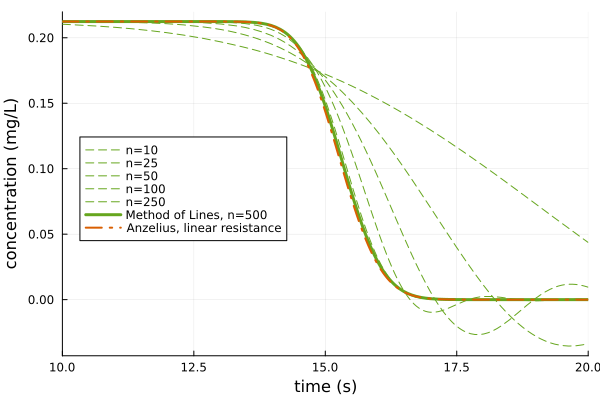

In [67]:
#| echo: false
#| label: fig-mol-conc
#| fig-cap: "Method of Lines with increasing <em>n</em>, converging slowly to the exact (Anzelius) solution."

let t=ustrip(t_shot), anz_eff = AnzeliusSolution(z, h_eff, pb), alg = Tsit5(thread=OrdinaryDiffEq.True());

Δx = (0.5, 1).*t

sol_10 = solve(ODEProblem(rhs!,parameters(10)...), alg)
sol_25 = solve(ODEProblem(rhs!,parameters(25)...), alg)
sol_50 = solve(ODEProblem(rhs!,parameters(50)...), alg)
sol_100 = solve(ODEProblem(rhs!,parameters(100)...), alg)
sol_250 = solve(ODEProblem(rhs!,parameters(250)...), alg)
sol_500 = solve(ODEProblem(rhs!,parameters(500)...), alg)

p1 = plot()
plot!(p1, t′ -> c(t′*1u"s", sol_10)/1000, xlim=Δx, label="n=10", color=colours[5], linestyle=:dash, lw=1)
plot!(p1, t′ -> c(t′*1u"s", sol_25)/1000, xlim=Δx, label="n=25", color=colours[5], linestyle=:dash, lw=1)
plot!(p1, t′ -> c(t′*1u"s", sol_50)/1000, xlim=Δx, label="n=50", color=colours[5], linestyle=:dash, lw=1)
plot!(p1, t′ -> c(t′*1u"s", sol_100)/1000, xlim=Δx, label="n=100", color=colours[5], linestyle=:dash, lw=1)
plot!(p1, t′ -> c(t′*1u"s", sol_250)/1000, xlim=Δx, label="n=250", color=colours[5], linestyle=:dash, lw=1)
plot!(p1, t′ -> c(t′*1u"s", sol_500)/1000, xlim=Δx, label="Method of Lines, n=500", color=colours[5], linestyle=:solid, lw=3)
plot!(p1, t′ -> c(t′*1u"s", anz_eff)/1000, xlim=Δx, label="Anzelius, linear resistance", color=colours[2], linestyle=:dashdot, lw=2)
plot!(p1, xlabel="time (s)", ylabel="concentration (mg/L)", legend=:left)
plot(p1)

end

Since I am ultimately modeling the same pde as was solved, exactly, by Anzelius I can plot the exact solution, showing that *n* must be quite large, &gt;500, to start to align with the correct answer. Were we to have used the full pde, with *n=m=500*, this would have required a 250,500 element state vector. This approach becomes severely computationally intensive rather quickly. That said, this is mostly an issue when the moving front is very sharp.

This can be alleviated by using a different discretization technique, such as moving finite element but, personally, there is a point where solving the pde gets complicated enough that it's easier to just use a multiphysics program like comsol than to try implementing it yourself.

## Conclusion

So far I have reviewed the "conventional" approach to packed bed mass transfer, examining the solutions that are recommended in the standard texts on unit operations and leaching[@schwartzberg-1987 pages 558-563]. All of these approaches over-estimate the initial concentration in the espresso because they assume the bed starts in equilibrium, though if the extraction runs for long enough these models fit the observed results better and better. An alternative approach is to assume the bed is filled with water that is not at equilibrium and the extraction only begins at t=0. This is the approach taken by much of the recent literature on modeling espresso[^32]. The downside to this approach is that it generally underestimates the initial concentration of the espresso.

[^32]: @cameron-2020 page 635; @moroney-2015 page 225; @guerra-2024 page 5

Since the initial conditions are different, none of the models above are directly comparable to the approaches taken in the literature. Though it should not be a huge undertaking to change the initial conditions after taking the Laplace transform and completing the result from there. Since the Laplace transform and its inverse are linear this should equate to adding an $\exp\left(...\right)$ term to the solution somewhere.

I think it is also reasonable to be skeptical of the mass transfer coefficients that I estimated. These are based on correlations for packed beds with spherical packing and, while I am modeling the particles as spheres, something may have been lost in the accounting. Most of the mass transfer coefficients ultimately depend upon a good estimate for the solid phase diffusion, which in this case I obtained from literature and is comparable to what one would expect for plant matter like coffee beans[@schwartzberg-1987 page 557]. But an obvious next step is to compare with actual measured data.

The model is also highly sensitive to particle size, which the figure below illustrates by successively doubling the effective diameter of the particles, while using the Rasmuson solution (all other parameters remaining equal). This diameter is also an *effective* parameter and not a directly measured one. It is the diameter of the sphere with an *equivalent surface area* to a coffee ground or, more accurately, the average of such diameters over the actual particle size distribution of the coffee grounds. This makes it somewhat difficult to determine exactly, especially if one is trying to incorporate the effects of microscopic pores on the effective surface area of coffee grounds. Rough estimates can be made using images taken of the grounds, using an app, but that will always be limited by the resolution of a camera.

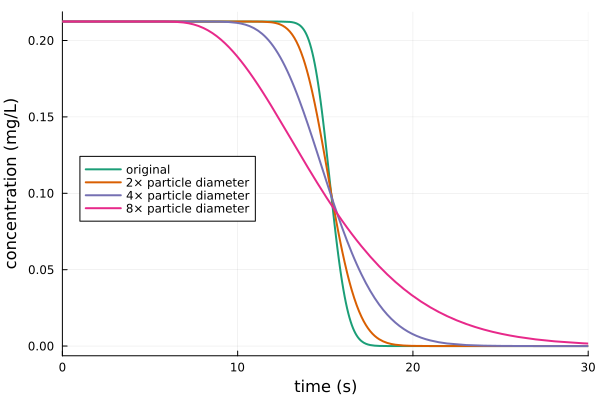

In [68]:
#| echo: false
#| label: fig-diam
#| fig-cap: "The impact of particle size on espresso extraction."

let t=ustrip(t_shot);

Δx = (0, 1.5).*t

pb_0 = RasmusonSolution(z, PackedBed(q_sat, K, 𝒟ₛ, 𝒟ₗ, h, ε, b, c₀, v); b=2.0)
pb_2 = RasmusonSolution(z, PackedBed(q_sat, K, 𝒟ₛ, 𝒟ₗ, h, ε, 2b, c₀, v); b=2.0)
pb_4 = RasmusonSolution(z, PackedBed(q_sat, K, 𝒟ₛ, 𝒟ₗ, h, ε, 4b, c₀, v); b=4.0)
pb_8 = RasmusonSolution(z, PackedBed(q_sat, K, 𝒟ₛ, 𝒟ₗ, h, ε, 8b, c₀, v); b=4.0)

p1 = plot()
plot!(p1, t′ -> c(t′*1u"s", pb_0)/1000, xlim=Δx, label="original", color=colours[1], linestyle=:solid, lw=2)
plot!(p1, t′ -> c(t′*1u"s", pb_2)/1000, xlim=Δx, label="2× particle diameter", color=colours[2], linestyle=:solid, lw=2)
plot!(p1, t′ -> c(t′*1u"s", pb_4)/1000, xlim=Δx, label="4× particle diameter", color=colours[3], linestyle=:solid, lw=2)
plot!(p1, t′ -> c(t′*1u"s", pb_8)/1000, xlim=Δx, label="8× particle diameter", color=colours[4], linestyle=:solid, lw=2)
plot!(p1, xlabel="time (s)", ylabel="concentration (mg/L)", legend=:left)
plot(p1)

end

Another note of caution is in using the direct numerical integration of the Rosen and Rasmussen solutions. In this notebook I specified the (finite) bounds of integration and the number of points to sample within the interval, which were tuned more or less by eye. That does mean the code is brittle to major changes in some of the packed bed parameters, without going back and re-tuning the parameters of the numerical integration. A more robust approach would determine some of these algorithmically, especially the bounds of integration. I could just leave the upper bound of the integral as `Inf`, but in my experience there can be domain issues if one isn't careful and the integrand isn't capturing all edge cases properly.

While I focused mostly on calculating the various integrals numerically, the asymptotic and approximate forms are probably more useful if you just want to play around and explore how changing different coffee parameters changes overall extraction. They are certainly easier to calculate.

## References
::: {#refs}
:::